In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [2]:
import pandas as pd

df = pd.read_csv("datasets/spam.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [6]:
# Downsampling
df_spam = df[df["Category"] == "spam"]
df_spam.shape

(747, 2)

In [8]:
df_ham = df[df["Category"] == "ham"].sample(747)
df_ham.shape

(747, 2)

In [9]:
df_balance = pd.concat([df_spam, df_ham])
df_balance.shape

(1494, 2)

In [10]:
df_balance.Category.value_counts()

Category
spam    747
ham     747
Name: count, dtype: int64

In [12]:
df_balance.sample(3)

,Category,Message
2338,ham,Tell your friends what you plan to do on Valen...
4520,ham,Just got part Nottingham - 3 hrs 63miles. Good...
5164,spam,Congrats 2 mobile 3G Videophones R yours. call...


In [14]:
df_balance['spam'] = df_balance['Category'].apply(lambda x: 1 if x == "spam" else 0)
df_balance.sample(5)

,Category,Message,spam
5378,spam,Free entry to the gr8prizes wkly comp 4 a chan...,1
433,spam,Congrats! Nokia 3650 video camera phone is you...,1
3711,ham,ARE YOU IN TOWN? THIS IS V. IMPORTANT,0
2204,ham,soon you will have the real thing princess! Do...,0
1142,spam,I don't know u and u don't know me. Send CHAT ...,1


In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_balance['Message'],
    df_balance['spam'],
    test_size=0.2,
    stratify=df_balance["spam"]
)

In [45]:
X_train.shape, y_train.shape

((1195,), (1195,))

In [46]:
X_train.head()

168     Hi frnd, which is best way to avoid missunders...
420     Send a logo 2 ur lover - 2 names joined by a h...
2365    Ok then no need to tell me anything i am going...
2940          Are you ok. What happen to behave like this
2480    Sppok up ur mob with a Halloween collection of...
Name: Message, dtype: object

In [47]:
preprocess_url = "https://kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-preprocess/3"
encoder_url = "https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-l-12-h-768-a-12/4"

In [48]:
bert_preprocess = hub.KerasLayer(preprocess_url)
bert_encoder = hub.KerasLayer(encoder_url)

In [49]:
def get_sentence_embedding(sentences):
    text_preprocessed = bert_preprocess(sentences)
    bert_result = bert_encoder(text_preprocessed)
    return bert_result['pooled_output']

get_sentence_embedding([
    "What do U want for Xmas?",
    "Hiya, had a good day?"
])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.9283166 , -0.52188164, -0.90034574, ..., -0.7631455 ,
        -0.7521075 ,  0.94395846],
       [-0.8889644 , -0.41560078, -0.89829564, ..., -0.7373032 ,
        -0.7248404 ,  0.89979535]], dtype=float32)>

In [50]:
e = get_sentence_embedding([
    "banana",
    "grapes",
    "mango", 
    "jeff bezos", 
    "elon musk",
    "bill gates"
])

In [51]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([e[4]], [e[3]])

array([[0.98720354]], dtype=float32)

**Sequential Vs Functional Model**

https://medium.com/@yashjhawi/tensorflow-keras-sequential-api-vs-functional-api-eaed7c96902b

So far we have built sequential model. But below we will build functional model. More information on these two is here: https://becominghuman.ai/sequential-vs-functional-model-in-keras-20684f766057

In [52]:
class Preprocess(tf.keras.layers.Layer):
    def call(self, inputs):
        return bert_preprocess(inputs)

class Encoder(tf.keras.layers.Layer):
    def call(self, inputs):
        return bert_encoder(inputs)

preprocess_model = Preprocess()
encoder_model = Encoder()
        
# BERT Layer
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
preprocessed_text = preprocess_model(text_input)
outputs = encoder_model(preprocessed_text)

# Neural Network Layer
dropout = tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])
last = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(dropout)

# construct final model
model = tf.keras.Model(inputs=[text_input], outputs=[last])

In [53]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None)            │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preprocess_1        │ [(None, 128),     │          0 │ text[0][0]        │
│ (Preprocess)        │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_1 (Encoder) │ [(None, 768),     │          0 │ preprocess_1[0][… │
│                     │ (None, 128, 768), │            │ preprocess_1[0][… │
│                     │ (None, 128, 768), │            │ preprocess_1[0][… │
│                     │ (None, 128, 768), │            │                   │
│                     │ (None, 128, 768), │            │                   │
│                     │ (None, 128, 768), │            │                   │
│                     │ (None, 128, 768), │            │                   │
│                     │ (None, 128, 768), │            │                   │
│                     │ (None, 128, 768), │            │                   │
│                     │ (None, 128, 768), │            │                   │
│                     │ (None, 128, 768), │            │                   │
│                     │ (None, 128, 768), │            │                   │
│                     │ (None, 128, 768), │            │                   │
│                     │ (None, 768),      │            │                   │
│                     │ (None, 128, 768)] │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 768)       │          0 │ encoder_1[0][13]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │        769 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name="recall")
]

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=METRICS)

In [55]:
X_train = X_train.astype(str).to_numpy()

model.fit(X_train, y_train, epochs=10)

Epoch 1/10


/Users/user/Desktop/PythonProject/myenv/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['text']
Received: inputs=Tensor(shape=(None,))
  warnings.warn(msg)


38/38 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.5990 - loss: 0.6631 - precision: 0.6128 - recall: 0.6752
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.7250 - loss: 0.5305 - precision: 0.7902 - recall: 0.6589
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.8462 - loss: 0.4399 - precision: 0.8247 - recall: 0.8897
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.8618 - loss: 0.4032 - precision: 0.8538 - recall: 0.8767
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.8910 - loss: 0.3549 - precision: 0.8779 - recall: 0.9171
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.8724 - loss: 0.3497 - precision: 0.8391 - recall: 0.9107
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.8934 - loss: 0.3029 - precision: 0.8695 - recall: 0.9317
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.8941 - loss: 0.3104 - precision: 0.8638 - recall: 0.9318
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 61s 2

In [56]:
X_test = X_test.astype(str).to_numpy()

model.evaluate(X_test, y_test)

/Users/user/Desktop/PythonProject/myenv/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['text']
Received: inputs=Tensor(shape=(None,))
  warnings.warn(msg)


10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9288 - loss: 0.2640 - precision: 0.9310 - recall: 0.9318


[0.27539971470832825,
 0.9163879752159119,
 0.9133333563804626,
 0.9194630980491638]

In [57]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

/Users/user/Desktop/PythonProject/myenv/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['text']
Received: inputs=Tensor(shape=(32,))
  warnings.warn(msg)


10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step


In [58]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1])

In [59]:
y_test

3399    0
2354    1
2945    1
5035    0
4507    0
       ..
1938    0
2340    0
4724    0
225     1
4746    1
Name: spam, Length: 299, dtype: int64

In [60]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[137,  13],
       [ 12, 137]])

Text(95.72222222222221, 0.5, 'Truth')

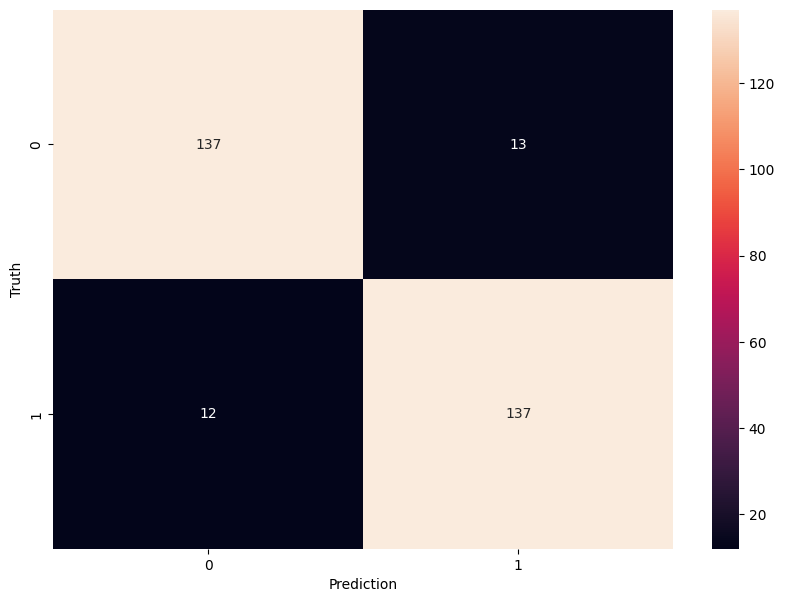

In [61]:
from matplotlib import pyplot as plt
import seaborn as sn

plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Prediction")
plt.ylabel("Truth")

In [62]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       150
           1       0.91      0.92      0.92       149

    accuracy                           0.92       299
   macro avg       0.92      0.92      0.92       299
weighted avg       0.92      0.92      0.92       299



In [76]:

reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]

# Convert to numpy array with dtype=object
review_array = np.array(reviews, dtype=object)

# Predict using a dict input to match the input layer name
predictions = model.predict({"text": review_array})

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


In [77]:
predictions

array([[0.6934964 ],
       [0.79543245],
       [0.72051495],
       [0.17022511],
       [0.08666938]], dtype=float32)